#  Modeling Protein-Ligand Interactions with Atomic Convolutions
By [Nathan C. Frey](https://ncfrey.github.io/) | [Twitter](https://twitter.com/nc_frey) and [Bharath Ramsundar](https://rbharath.github.io/) | [Twitter](https://twitter.com/rbhar90)

This DeepChem tutorial introduces the [Atomic Convolutional Neural Network](https://arxiv.org/pdf/1703.10603.pdf). We'll see the structure of the `AtomicConvModel` and write a simple program to run Atomic Convolutions.

### ACNN Architecture
ACNN’s directly exploit the local three-dimensional structure of molecules to hierarchically learn more complex chemical features by optimizing both the model and featurization simultaneously in an end-to-end fashion.

The atom type convolution makes use of a neighbor-listed distance matrix to extract features encoding local chemical environments from an input representation (Cartesian atomic coordinates) that does not necessarily contain spatial locality. The following methods are used to build the ACNN architecture:

- __Distance Matrix__  
The distance matrix $R$ is constructed from the Cartesian atomic coordinates $X$. It calculates distances from the distance tensor $D$. The distance matrix construction accepts as input a $(N, 3)$ coordinate matrix $C$. This matrix is “neighbor listed” into a $(N, M)$ matrix $R$.

```python
    R = tf.reduce_sum(tf.multiply(D, D), 3)     # D: Distance Tensor
    R = tf.sqrt(R)                              # R: Distance Matrix
    return R
```

- **Atom type convolution**  
The output of the atom type convolution is constructed from the distance matrix $R$ and atomic number matrix $Z$. The matrix $R$ is fed into a (1x1) filter with stride 1 and depth of $N_{at}$ , where $N_{at}$ is the number of unique atomic numbers (atom types) present in the molecular system. The atom type convolution kernel is a step function that operates on the neighbor distance matrix $R$.

- **Radial Pooling layer**  
Radial Pooling is basically a dimensionality reduction process that down-samples the output of the atom type convolutions. The reduction process prevents overfitting by providing an abstracted form of representation through feature binning, as well as reducing the number of parameters learned.
Mathematically, radial pooling layers pool over tensor slices (receptive fields) of size (1x$M$x1) with stride 1 and a depth of $N_r$, where $N_r$ is the number of desired radial filters and $M$ is the maximum number of neighbors.

- **Atomistic fully connected network**  
Atomic Convolution layers are stacked by feeding the flattened ($N$, $N_{at}$ $\cdot$ $N_r$) output of the radial pooling layer into the atom type convolution operation. Finally, we feed the tensor row-wise (per-atom) into a fully-connected network. The
same fully connected weights and biases are used for each atom in a given molecule.

Now that we have seen the structural overview of ACNNs, we'll try to get deeper into the model and see how we can train it and what we expect as the output.

For the training, we will use the publicly available PDBbind dataset. In this example, every row reflects a protein-ligand complex and the target is the binding affinity ($K_i$) of the ligand to the protein in the complex.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions_With_Atomic_Convolutions.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
# # Download Miniconda if not already installed
# wget https://repo.anaconda.com/miniconda/Miniconda3-latest-MacOSX-x86_64.sh
# bash Miniconda3-latest-MacOSX-x86_64.sh

# # Then create a conda env
# conda create -n atomic python=3.10
# conda activate atomic
# conda install -c conda-forge pycosat mdtraj pdbfixer openmm


In [2]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
/Users/sanskriti/miniconda3/envs/atomic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models

'2.8.1.dev'

In [3]:
 ##you need to use conda for tensorflow.in your terminal
# conda install -c conda-forge tensorflow 

import deepchem as dc
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from rdkit import Chem

from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

## 1) Getting protein-ligand data
If you're testing ideas quickly, play with the 'core' dataset with ~200 complexes. Otherwise, play with the 'refined' dataset, with 4000+ complexes.
Note that the refined dataset takes ~1 hour to download the first time (core = 5 minutes), and it takes about 13 minutes to run the load_pdbbind cell if it is not your first time running.

In [4]:
f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)

In [5]:
# ls ./pdbbind_refined_ac_/

`load_pdbbind` allows us to specify if we want to use the entire protein or only the binding pocket (`pocket=True`) for featurization. Using only the pocket saves memory and speeds up the featurization. We can also use the "core" dataset of ~200 high-quality complexes for rapidly testing our model, or the larger "refined" set of nearly 5000 complexes for more datapoints and more robust training/validation. On Colab, it takes only a minute to featurize the core PDBbind set! This is pretty incredible, and it means you can quickly experiment with different featurizations and model architectures.

In [6]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=True, #so if already downloaded, it won't download again
                                             set_name='core')

CPU times: user 5.84 ms, sys: 3.3 ms, total: 9.14 ms
Wall time: 11.5 ms


Unfortunately, if you try to use the "refined" dataset, there are some complexes that cannot be featurized. To resolve this issue, rather than increasing `complex_num_atoms`, simply omit the lines of the dataset that have an `x` value of `None`

In [7]:
%%time
def clean_dataset(dataset):
    kept_indices = [i for i, x in enumerate(dataset.X) if x is not None]
    return dc.data.NumpyDataset(
        X=np.array([dataset.X[i] for i in kept_indices], dtype=object),
        y=np.array([dataset.y[i] for i in kept_indices]),
        w=np.array([dataset.w[i] for i in kept_indices]),
        ids=[dataset.ids[i] for i in kept_indices]
    )

datasets = [clean_dataset(d) for d in datasets]


for i, d in enumerate(datasets):
    has_none = any(xi is None for xi in d.X)
    print(f"Dataset {i} has None entries in X? {has_none}")






Dataset 0 has None entries in X? False
Dataset 1 has None entries in X? False
Dataset 2 has None entries in X? False
CPU times: user 302 ms, sys: 73.9 ms, total: 376 ms
Wall time: 539 ms


In [8]:
datasets

[<NumpyDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['1sln' '2qft' '3oe5' ... '3pxf' '2xnb' '2v00'], task_names: [0]>,
 <NumpyDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['3pww' '3ao4' '1uto' ... '2zxd' '4gid' '1qi0'], task_names: [0]>,
 <NumpyDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['2zx6' '2wtv' '1u33' ... '1o5b' '2v7a' '2x0y'], task_names: [0]>]

In [9]:
train, val, test = datasets

class ZeroImputer(dc.trans.Transformer):
    def __init__(self):
        # Only transform y, leave X and w alone
        super().__init__(transform_X=False, transform_y=True)

    def transform_array(self, X, y, w, ids):
        # X: leave it as-is
        # y: copy and fill NaNs
        y_out = np.array(y, copy=True)
        # This will now work, because y_out is a numeric array
        y_out[np.isnan(y_out)] = 0.0
        return X, y_out, w, ids

imputer = ZeroImputer()
train = imputer.transform(train)
val   = imputer.transform(val)

In [10]:
## remember to do this in terminal: pip install --upgrade git+https://github.com/deepchem/deepchem.git
import deepchem
print(deepchem.models.atomic_conv.__file__)

/Users/sanskriti/miniconda3/envs/atomic/lib/python3.10/site-packages/deepchem/models/atomic_conv.py


In [11]:
from deepchem.models import AtomicConvModel

model1 = AtomicConvModel(
    n_tasks=1,
    frag1_num_atoms=70,
    frag2_num_atoms=60,
    complex_num_atoms=130,
    max_num_neighbors=4,
    batch_size=4,
    layer_sizes=[32, 32, 16],
    learning_rate=0.001
)


# 2) Training the model
Note that the val_cb will take ~1.7 hour if you're using the refined set. If you do not want to train it yourself and use the weights that we have, just skip the next couple of cells, and comment out the cell as indicated.

Got values for `AtomicConvModel` to train. Keep the input parameters the same as those used in `AtomicConvFeaturizer`, or else we'll get errors. `layer_sizes` controls the number of layers and the size of each dense layer in the network. We choose these hyperparameters to be the same as those used in the [original paper](https://arxiv.org/pdf/1703.10603.pdf).

In [20]:
acm1 = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[64, 64, 32],    # a bit larger
                      learning_rate=0.003,
                      weight_decay=1e-4,           # L2 penalty on weights
                      dropout=0.2     
                      )

In [21]:
losses, val_losses = [], []

In [22]:
# %%time
# max_epochs = 50

metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
# step_cutoff = len(train)//12
# def val_cb(model, step):
#   if step%step_cutoff!=0:
#       return
#   val_losses.append(model.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss
#   losses.append(model.evaluate(train, metrics=[metric])['rms_score']**2)  # L2 Loss

# acm.fit(train, nb_epoch=max_epochs, max_checkpoints_to_keep=1,
#                 callbacks=[val_cb])

In [23]:
from itertools import chain
max_epochs = 15

import numpy as np
import deepchem as dc
from itertools import chain

# 1) Turn your AtomicConvModel into a factory
def build_model():
    return dc.models.AtomicConvModel(
        n_tasks=1,
        frag1_num_atoms=f1_num_atoms,
        frag2_num_atoms=f2_num_atoms,
        complex_num_atoms=f1_num_atoms + f2_num_atoms,
        max_num_neighbors=max_num_neighbors,
        batch_size=12,
        layer_sizes=[32, 32, 16],
        learning_rate=0.003,
    )

# 2) Prepare your metric and (optional) callback
metric     = dc.metrics.Metric(dc.metrics.score_function.rms_score)
max_epochs = 15

def val_cb(model, step, iteration_loss=None):
    # e.g. print every N steps if you want
    if step % (len(train_ds) // 12) != 0:
        return
    epoch = step // (len(train_ds) // 12)
    train_l2 = model.evaluate(train_ds, metrics=[metric])['rms_score']**2
    val_l2   = model.evaluate(valid_ds, metrics=[metric])['rms_score']**2
    print(f"Epoch {epoch}/{max_epochs}: Train L₂={train_l2:.4f}, Val L₂={val_l2:.4f}")

# 3) Run 3-fold “leave-one-dataset-out” CV
cv_scores = []
import numpy as np
import pandas as pd
from itertools import chain

all_results = []

for fold_idx in range(len(datasets)):
    # a) pick validation and re-build train_ds as before
    valid_ds   = datasets[fold_idx]
    train_parts = [d for i,d in enumerate(datasets) if i!=fold_idx]
    X_tr = np.concatenate([d.X for d in train_parts], axis=0)
    y_tr = np.concatenate([d.y for d in train_parts], axis=0)
    w_tr = np.concatenate([d.w for d in train_parts], axis=0)
    ids_tr = list(chain.from_iterable(d.ids for d in train_parts))
    train_ds = dc.data.NumpyDataset(X_tr, y_tr, w_tr, ids_tr)

    # b) fresh model, fit, then predict
    model = build_model()
    model.fit(train_ds, nb_epoch=max_epochs, callbacks=[val_cb])

    raw_preds = model.predict(valid_ds)
    preds     = np.concatenate(raw_preds).ravel()

    # c) assemble fold DataFrame
    df = pd.DataFrame({
        'Fold':      fold_idx+1,
        'ID':        valid_ds.ids,
        'Actual':    valid_ds.y,
        'Predicted': preds
    })
    df['Residual'] = df['Actual'] - df['Predicted']
    all_results.append(df)

# concatenate and inspect
results_df = pd.concat(all_results, ignore_index=True)
print(results_df)



Epoch 1/15: Train L₂=1.6236, Val L₂=1.7224
Epoch 2/15: Train L₂=1.4139, Val L₂=1.5390
Epoch 3/15: Train L₂=1.1477, Val L₂=1.3190
Epoch 4/15: Train L₂=0.8175, Val L₂=1.0568
Epoch 5/15: Train L₂=0.5461, Val L₂=0.8427
Epoch 6/15: Train L₂=0.4457, Val L₂=0.7587
Epoch 7/15: Train L₂=0.4291, Val L₂=0.7584
Epoch 8/15: Train L₂=0.3879, Val L₂=0.7612
Epoch 9/15: Train L₂=0.4570, Val L₂=0.8517
Epoch 10/15: Train L₂=0.5521, Val L₂=0.9512
Epoch 11/15: Train L₂=0.5727, Val L₂=0.9898
Epoch 12/15: Train L₂=0.5150, Val L₂=0.9681
Epoch 13/15: Train L₂=0.4225, Val L₂=0.9135
Epoch 14/15: Train L₂=0.3352, Val L₂=0.8539
Epoch 15/15: Train L₂=0.2658, Val L₂=0.8029
Epoch 16/15: Train L₂=0.2320, Val L₂=0.7830
Epoch 17/15: Train L₂=0.2188, Val L₂=0.7818
Epoch 18/15: Train L₂=0.2219, Val L₂=0.7933
Epoch 19/15: Train L₂=0.2259, Val L₂=0.8041
Epoch 20/15: Train L₂=0.2040, Val L₂=0.7910
Epoch 1/15: Train L₂=0.6756, Val L₂=0.5982
Epoch 2/15: Train L₂=0.6814, Val L₂=0.8255
Epoch 3/15: Train L₂=0.5121, Val L₂=0.6848


In [16]:
import numpy as np
import pandas as pd

# 1) Predict. DeepChem returns a list of arrays, so concatenate if necessary:
raw_preds = model.predict(valid_ds)  
# If predict() returns a list of shape (n_samples,1), flatten it:
preds = np.concatenate(raw_preds).ravel()

# 2) Grab the true labels and IDs:
actuals = valid_ds.y
ids      = valid_ds.ids

# 3) Build a DataFrame:
df = pd.DataFrame({
    'ID':        ids,
    'Actual':    actuals,
    'Predicted': preds,
})

# 4) Show the whole table or just the first few rows:
print(df.head(20))   # first 20 rows
#—or—
print(df)            # entire table

# Optional: if you’re in Streamlit, you can do:
# st.write(df)


      ID    Actual  Predicted
0   2zx6  1.933551   0.906781
1   2wtv  1.100700   1.017838
2   1u33 -0.753067   0.413173
3   2vl4 -0.121712   0.189188
4   2xys  0.509643   0.072913
5   3bpc -0.663513   0.021109
6   1sqa  1.311151   1.053379
7   1w3l -0.000814   0.557791
8   1f8c  0.500688  -0.107328
9   2d1o  0.635019   0.769117
10  3d4z -0.623214  -0.602493
11  2pcp  1.082789   0.204326
12  3nq3 -1.120239   0.169103
13  1p1q -0.623214   0.244873
14  1igj  1.664889   0.366287
15  2yfe  0.155905   0.904374
16  3vh9 -0.018725  -0.104235
17  1o5b -0.229177  -0.320564
18  2v7a  0.903681   1.078041
19  2x0y -0.753067   0.994955
      ID    Actual  Predicted
0   2zx6  1.933551   0.906781
1   2wtv  1.100700   1.017838
2   1u33 -0.753067   0.413173
3   2vl4 -0.121712   0.189188
4   2xys  0.509643   0.072913
5   3bpc -0.663513   0.021109
6   1sqa  1.311151   1.053379
7   1w3l -0.000814   0.557791
8   1f8c  0.500688  -0.107328
9   2d1o  0.635019   0.769117
10  3d4z -0.623214  -0.602493
11  2pcp  

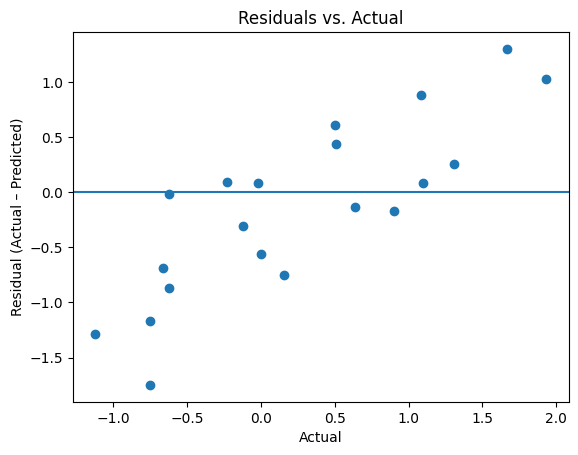

In [19]:
residuals = actuals - preds
plt.figure()
plt.scatter(actuals, residuals)
plt.axhline(0)
plt.xlabel('Actual')
plt.ylabel('Residual (Actual – Predicted)')
plt.title('Residuals vs. Actual')
plt.show()


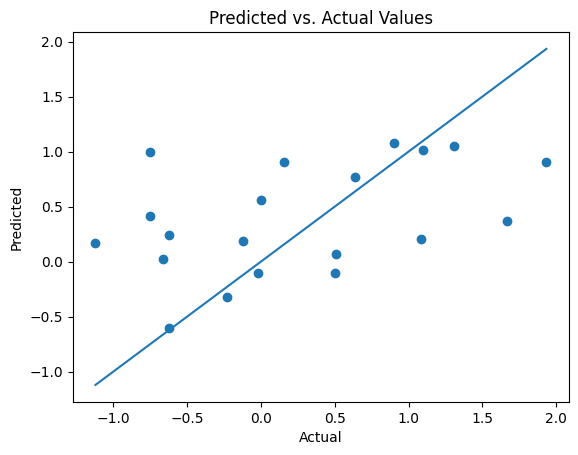

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Re-compute your predictions and labels
raw_preds = model.predict(valid_ds)           # list of (n_samples,1) arrays
preds     = np.concatenate(raw_preds).ravel() # flatten to (n_samples,)
actuals   = valid_ds.y                        # true values

# Make the scatter plot
plt.figure()
plt.scatter(actuals, preds)

# Add y = x reference line
min_val = min(actuals.min(), preds.min())
max_val = max(actuals.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Values')
plt.show()


## Save the model somewhere

In [17]:
## You need to save the model to use it later. Make sure you save it to the right directory.
# Save model to a directory
model_dir = './saved_atomic_model'
acm1.save_checkpoint(model_dir)

TypeError: '<=' not supported between instances of 'str' and 'int'

## 2a) If you don't want to spend ~1 hour running the training, you can upload it by uncommenting the following cell.

In [ ]:
# from deepchem.models import AtomicConvModel

# # Recreate the model with the same architecture
# acm_reloaded = AtomicConvModel(
#     n_tasks=1,
#     frag1_num_atoms=70,  # same as used before
#     frag2_num_atoms=60,
#     complex_num_atoms=130,
#     max_num_neighbors=4,
#     batch_size=4,
#     layer_sizes=[32, 32, 16],
#     learning_rate=0.001
# )

# # Restore weights from checkpoint
# acm_reloaded.restore(model_dir)


## 3) Visualize loss curves, successful guessing, etc.
The loss curves are not exactly smooth, which is unsurprising because we are using 154 training and 19 validation datapoints. Increasing the dataset size may help with this, but will also require greater computational resources.

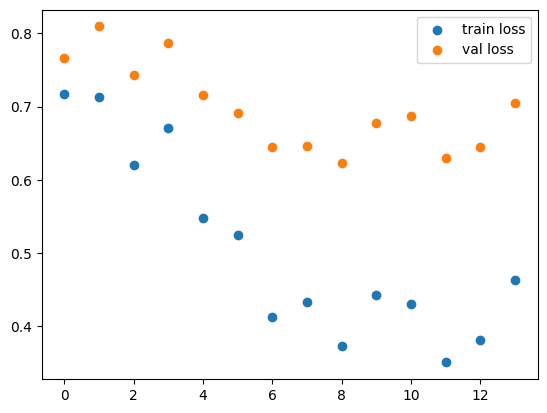

In [ ]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

The [ACNN paper](https://arxiv.org/pdf/1703.10603.pdf) showed a Pearson $R^2$ score of 0.912 and 0.448 for a random 80/20 split of the PDBbind core train/test sets. Here, we've used an 80/10/10 training/validation/test split and achieved similar performance for the training set (0.943). We can see from the performance on the training, validation, and test sets (and from the results in the paper) that the ACNN can learn chemical interactions from small training datasets, but struggles to generalize. Still, it is pretty amazing that we can train an `AtomicConvModel` with only a few lines of code and start predicting binding affinities!  
From here, you can experiment with different hyperparameters, more challenging splits, and the "refined" set of PDBbind to see if you can reduce overfitting and come up with a more robust model.

In [ ]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)
for tvt, ds in zip(['train', 'val', 'test'], datasets):
  print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': nan}
val {'pearson_r2_score': 0.3798254791375694}
test {'pearson_r2_score': nan}


In [ ]:
import numpy as np

predicted = acm.predict(val)  # shape: (n_samples, 1)
actual = val.y  # shape: (n_samples,)

# Flatten predictions if needed
predicted = predicted.flatten()

# Display a few values
for i in range(min(10, len(actual))):
    print(f"Actual: {actual[i]:.4f}, Predicted: {predicted[i]:.4f}")


Actual: 1.0371, Predicted: 0.4835
Actual: 2.1097, Predicted: 1.3458
Actual: -0.4690, Predicted: -0.6806
Actual: -0.3027, Predicted: 0.4518
Actual: -0.0706, Predicted: 0.0807
Actual: 0.2359, Predicted: 0.3877
Actual: -0.3289, Predicted: 1.0871
Actual: -1.7781, Predicted: -0.9164
Actual: -0.2458, Predicted: -0.1711
Actual: 0.7131, Predicted: 0.4641


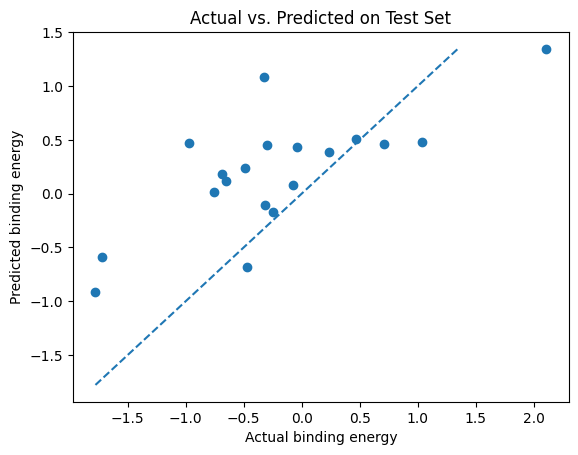

In [ ]:
plt.scatter(actual, predicted)
plt.plot([actual.min(), predicted.max()],
         [actual.min(), predicted.max()],
         ls="--")  # diagonal line
plt.xlabel("Actual binding energy")
plt.ylabel("Predicted binding energy")
plt.title("Actual vs. Predicted on Test Set")
plt.show()


### Further reading
We have explored the ACNN architecture and used the PDBbind dataset to train an ACNN to predict protein-ligand binding energies. For more information, read the original paper that introduced ACNNs: Gomes, Joseph, et al. "Atomic convolutional networks for predicting protein-ligand binding affinity." [arXiv preprint arXiv:1703.10603](https://arxiv.org/abs/1703.10603) (2017). There are many other methods and papers on predicting binding affinities. Here are a few interesting ones to check out: predictions using [only ligands or proteins](https://www.frontiersin.org/articles/10.3389/fphar.2020.00069/full), [molecular docking with deep learning](https://chemrxiv.org/articles/preprint/GNINA_1_0_Molecular_Docking_with_Deep_Learning/13578140), and [AtomNet](https://arxiv.org/abs/1510.02855).

In [ ]:
from qiskit.primitives import Estimator, Sampler
from qiskit_machine_learning.algorithms import VQR


## Quantum stuff
If testing, change set_name to 'core'. If want big, refined

In [ ]:
# 1) IMPORTS & DATA LOADING
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from deepchem.molnet import load_pdbbind
# Qiskit ML pieces
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.algorithms import VQR
from qiskit.primitives import Estimator
from scipy.optimize import minimize

# 2) LOAD DEEPCHEM DATA
# (assumes you've already run your AtomicConvFeaturizer load & MyTransformer steps)
tasks, datasets, transformers = load_pdbbind(
    featurizer=acf,
    save_dir='.',
    data_dir='.',
    pocket=True,
    reload=True,  # so if already downloaded, it won't download again
    set_name='refined'
)
train, val, test = datasets
X_train_dc, y_train = train.X, train.y
X_val_dc,   y_val   = val.X,   val.y
X_test_dc,  y_test  = test.X,  test.y



# 3) FLATTEN DeepChem FEATURES → CLASSICAL MATRIX
def flatten_dc_features(X_dc):
    rows = []
    for sample in X_dc:
        pieces = []
        for comp in sample:
            # only flatten real numpy arrays
            if isinstance(comp, np.ndarray):
                pieces.append(comp.ravel())
        # join all the numeric pieces
        vec = np.concatenate(pieces)
        rows.append(vec)
    # make into one (n_samples, n_features) float64 array
    flat = np.vstack(rows).astype(np.float64)
    return flat

# then:
X_train_flat = flatten_dc_features(X_train_dc)
print("train flat:", X_train_flat.shape, X_train_flat.dtype)
X_val_flat   = flatten_dc_features(X_val_dc)
X_test_flat  = flatten_dc_features(X_test_dc)


# 4) SCALE + PCA → N‐QUBIT INPUT VECTORS
n_qubits = 6  # pick based on your simulator capacity
# scale into [−π,π] so feature_map rotations stay numeric
fm_scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_all = fm_scaler.fit_transform(
    np.vstack([X_train_flat, X_val_flat, X_test_flat])
)
pca = PCA(n_components=n_qubits)
X_all_pca = pca.fit_transform(X_all)

# split back
N_train = X_train_flat.shape[0]
N_val   = X_val_flat.shape[0]
X_train_pca = X_all_pca[:N_train]
X_val_pca   = X_all_pca[N_train:N_train+N_val]
X_test_pca  = X_all_pca[N_train+N_val:]

# scale targets y into [−1,+1] for single‐qubit range
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).ravel()

y_val_scaled   = y_scaler.transform(y_val.reshape(-1,1)).ravel()
y_test_scaled  = y_scaler.transform(y_test.reshape(-1,1)).ravel()

[00:26:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[00:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

train flat: (3881, 8800) float64


In [ ]:



# # 5) BUILD THE QCNN CIRCUIT
# # 5.1 Feature map
# feature_map = ZFeatureMap(feature_dimension=n_qubits, reps=1)

# # 5.2 A simple “1‐conv + 1‐pool” QCNN block for illustration
# from qiskit import QuantumCircuit
# from qiskit.circuit import ParameterVector

# def conv_instruction(n, prefix):
#     params = ParameterVector(prefix, length=3*n)
#     qc = QuantumCircuit(n, name="Conv")
#     idx = 0
#     for q1,q2 in zip(range(0,n,2), range(1,n,2)):
#         sub = QuantumCircuit(2)
#         sub.rz(-np.pi/2, 1)
#         sub.cx(1,0)
#         sub.rz(params[idx],   0)
#         sub.ry(params[idx+1], 1)
#         sub.cx(0,1)
#         sub.ry(params[idx+2], 1)
#         qc.compose(sub, [q1,q2], inplace=True)
#         qc.barrier()
#         idx += 3
#     return qc.to_instruction()

# def pool_instruction(srcs, sinks, prefix):
#     params = ParameterVector(prefix, length=3*len(srcs))
#     n = len(srcs)+len(sinks)
#     qc = QuantumCircuit(n, name="Pool")
#     idx = 0
#     for s,t in zip(srcs, sinks):
#         sub = QuantumCircuit(2)
#         sub.rz(-np.pi/2, 1)
#         sub.cx(1,0)
#         sub.rz(params[idx],   0)
#         sub.ry(params[idx+1], 1)
#         sub.cx(0,1)
#         sub.ry(params[idx+2], 1)
#         qc.compose(sub, [s,t], inplace=True)
#         qc.barrier()
#         idx += 3
#     return qc.to_instruction()

# # Assemble: fmap → conv → pool → measure Z⊗… at end
# qc_cnn = QuantumCircuit(n_qubits)
# # qc_cnn.compose(feature_map, range(n_qubits), inplace=True)
# qc_cnn.append(conv_instruction(n_qubits, "c1"), range(n_qubits))
# # example pooling halving qubits [0→n/2],[1→n/2+1],…
# src = list(range(0,n_qubits,2))
# snk = list(range(1,n_qubits,2))
# qc_cnn.append(pool_instruction(src, snk, "p1"), range(n_qubits))
# # now only n_qubits/2 logical remain; you’d repeat conv+pool until 1 remains


# def lbfgs_b_opt(fun, x0, jac=None, bounds=None):
#     return minimize(
#         fun,
#         x0,
#         method="L-BFGS-B",
#         jac=jac,
#         bounds=bounds,
#         options={"maxiter": 150},
#     )


# # 6) WRAP IN A VQR & TRAIN
# vqr = VQR(
#     num_qubits=n_qubits,
#     feature_map=feature_map,
#     ansatz=qc_cnn,
#     optimizer=lbfgs_b_opt,
#     estimator=Estimator(),
# )

# # fit on train, validate on val
# vqr.fit(X_train_pca, y_train_scaled)
# y_val_pred_scaled = vqr.predict(X_val_pca)
# y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).ravel()

# # 7) EVALUATE ON TEST
# y_test_pred_scaled = vqr.predict(X_test_pca)
# y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1,1)).ravel()

# # Now you have y_test_pred in the original binding‐energy units!


In [ ]:
# ### testing
# print([row.shape for row in X_train_flat[:5]])
# print(np.array(X_train_flat).dtype)


In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Actual":    y_test,
    "Predicted": y_test_pred
})
print(df)


NameError: name 'y_test' is not defined

In [ ]:
# import matplotlib.pyplot as plt

# plt.scatter(y_test, y_test_pred)
# plt.plot([y_test.min(), y_test.max()],
#          [y_test.min(), y_test.max()],
#          ls="--")  # diagonal line
# plt.xlabel("Actual binding energy")
# plt.ylabel("Predicted binding energy")
# plt.title("Actual vs. Predicted on Test Set")
# plt.show()


## hybrid

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import TensorDataset, DataLoader

# from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
# from qiskit.primitives import Estimator as QiskitEstimator
# from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN  # :contentReference[oaicite:0]{index=0}
# from qiskit_machine_learning.connectors.torch_connector import TorchConnector


# from qiskit.quantum_info import SparsePauliOp


# from qiskit.primitives import Estimator as QiskitEstimator
# from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN

# from qiskit.quantum_info import SparsePauliOp


# # 1) HYPERPARAMETERS
# n_qubits      = 6
# batch_size    = 16
# learning_rate = 1e-3
# n_epochs      = 3
# D             = X_train_flat.shape[1]   # total # of classical features

# # 2) BUILD THE QUANTUM LAYER (EstimatorQNN version)
# feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2)
# ansatz      = RealAmplitudes(num_qubits=n_qubits, reps=2)
# qc_circuit  = feature_map.compose(ansatz)

# # measure Z on qubit 0 → one real expectation value
# obs = SparsePauliOp.from_list([
#     ("Z" * n_qubits, 1.0)   # e.g. "ZZZZZZ" for 6 qubits
# ])

# # wrap the Estimator primitive
# primitive     = QiskitEstimator()
# estimator_qnn = EstimatorQNN(
#     circuit      = qc_circuit,
#     input_params = feature_map.parameters,
#     weight_params= ansatz.parameters,
#     observables  = obs,
#     estimator    = primitive,
# )
# quantum_layer = TorchConnector(estimator_qnn)

# # 3) DEFINE THE HYBRID 1D‐CNN
# class HybridCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
#         self.pool  = nn.MaxPool1d(2)
#         self.fc1   = nn.Linear(32 * (D//2), n_qubits)
#         self.qc    = quantum_layer
#         self.fc2   = nn.Linear(1, 1)

#     def forward(self, x):
#         x = x.unsqueeze(1)            # (batch, D) → (batch,1,D)
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)     # → (batch, 32*(D/2))
#         x = self.fc1(x)               # → (batch, n_qubits)
#         x = self.qc(x)                # → (batch,1)
#         # x = torch.tanh(x)         # or F.relu(x) #########################
#         x = self.fc2(x)               # → (batch,1)
#         return x.squeeze(-1)          # → (batch,)

# # 4) CREATE DATALOADERS
# train_ds = TensorDataset(
#     torch.tensor(X_train_flat, dtype=torch.float32),
#     torch.tensor(y_train_scaled, dtype=torch.float32)
# )
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# val_ds = TensorDataset(
#     torch.tensor(X_val_flat, dtype=torch.float32),
#     torch.tensor(y_val_scaled, dtype=torch.float32)
# )
# val_loader = DataLoader(val_ds, batch_size=batch_size)

# # 5) TRAIN
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model  = HybridCNN().to(device)
# opt    = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = nn.MSELoss()

# for epoch in range(1, n_epochs+1):
#     model.train()
#     train_loss = 0.0
#     for Xb, yb in train_loader:
#         Xb, yb = Xb.to(device), yb.to(device)
#         opt.zero_grad()
#         loss = loss_fn(model(Xb), yb)
#         loss.backward()
#         opt.step()
#         train_loss += loss.item()*Xb.size(0)
#     train_loss /= len(train_loader.dataset)

#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for Xb, yb in val_loader:
#             Xb, yb = Xb.to(device), yb.to(device)
#             val_loss += loss_fn(model(Xb), yb).item()*Xb.size(0)
#     val_loss /= len(val_loader.dataset)

#     print(f"Epoch {epoch:3d}  Train MSE: {train_loss:.4f}  Val MSE: {val_loss:.4f}")

# # 6) TEST
# model.eval()
# X_test_t = torch.tensor(X_test_flat, dtype=torch.float32).to(device)
# with torch.no_grad():
# #     y_test_pred_scaled = model(X_test_t).cpu().numpy()
# # y_test_pred = y_scaler.inverse_transform(
# #     y_test_pred_scaled.reshape(-1,1)
# # ).ravel()
#     y_test_pred_scaled = model(X_test_t).cpu().numpy()
#     # invert scaling
#     y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1,1)).ravel()
# print("Test predictions:", y_test_pred, "Actual:", y_test)


In [ ]:
# import pandas as pd

# df = pd.DataFrame({
#     "Actual":    y_test_scaled,
#     "Predicted": y_test_pred_scaled
# })
# print(df)


In [ ]:
# import matplotlib.pyplot as plt

# plt.scatter(y_test, y_test_pred)
# plt.plot([y_test.min(), y_test.max()],
#          [y_test.min(), y_test.max()],
#          ls="--")  # diagonal line
# plt.xlabel("Actual binding energy")
# plt.ylabel("Predicted binding energy")
# plt.title("Actual vs. Predicted on Test Set")
# plt.show()


## consider: getting six outputs instead

In [ ]:
n_epochs = 20
batch_size = 50

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN  # :contentReference[oaicite:0]{index=0}
from qiskit_machine_learning.connectors.torch_connector import TorchConnector

from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN
from qiskit_machine_learning.connectors.torch_connector import TorchConnector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# 1) Quantum layer: deeper maps + per-qubit observables
feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2)
ansatz      = RealAmplitudes(num_qubits=n_qubits, reps=2)
qc_circuit  = feature_map.compose(ansatz)

# build an observable list that measures Z on *each* qubit separately
pauli_list = [
    ("I"*i + "Z" + "I"*(n_qubits-1-i), 1.0)
    for i in range(n_qubits)
]
obs = SparsePauliOp.from_list(pauli_list)

primitive     = QiskitEstimator()
estimator_qnn = EstimatorQNN(
    circuit      = qc_circuit,
    input_params = feature_map.parameters,
    weight_params= ansatz.parameters,
    observables  = obs,
    estimator    = primitive,
)
quantum_layer = TorchConnector(estimator_qnn)  # now returns (batch, n_qubits)

# 2) Updated HybridCNN with 6-channel Q-features
class HybridCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool1d(2)
        self.fc1   = nn.Linear(32 * (D//2), n_qubits)
        self.qc    = quantum_layer
        # now collapse 6 → 16 via a tiny MLP before final scalar
        self.mlp   = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)            # (B, D) → (B,1,D)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)     # → (B, 32*(D/2))
        x = self.fc1(x)               # → (B, n_qubits)
        x = self.qc(x)                # → (B, n_qubits)  (6 expectations)
        x = self.mlp(x)               # → (B,1)
        return x.squeeze(-1)          # → (B,)
    
    # 3) DEFINE THE HYBRID 1D‐CNN
class HybridCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool1d(2)
        self.fc1   = nn.Linear(32 * (D//2), n_qubits)
        self.qc    = quantum_layer
        self.fc2   = nn.Linear(1, 1)

    def forward(self, x):
        x = x.unsqueeze(1)            # (batch, D) → (batch,1,D)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)     # → (batch, 32*(D/2))
        x = self.fc1(x)               # → (batch, n_qubits)
        x = self.qc(x)                # → (batch,1)
        # x = torch.tanh(x)         # or F.relu(x) #########################
        x = self.fc2(x)               # → (batch,1)
        return x.squeeze(-1)          # → (batch,)

# 4) CREATE DATALOADERS
train_ds = TensorDataset(
    torch.tensor(X_train_flat, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = TensorDataset(
    torch.tensor(X_val_flat, dtype=torch.float32),
    torch.tensor(y_val_scaled, dtype=torch.float32)
)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# 5) TRAIN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = HybridCNN().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(Xb), yb)
        loss.backward()
        
        # for troubleshooting, print gradients
        for name, p in model.named_parameters():
            if "qc" in name and p.grad is not None:
                print(f"{name} grad norm = {p.grad.norm().item():.3e}")

        opt.step()
        train_loss += loss.item()*Xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            val_loss += loss_fn(model(Xb), yb).item()*Xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:3d}  Train MSE: {train_loss:.4f}  Val MSE: {val_loss:.4f}")
    # prepare a fixed tensor for validation inputs
    X_val_t = torch.tensor(X_val_flat, dtype=torch.float32).to(device)

    if epoch % 1 == 0:
        model.eval()
        with torch.no_grad():
            pred = model(X_val_t).cpu().numpy()
        plt.scatter(y_val_scaled, pred); plt.plot([-1,1],[-1,1], '--'); plt.show()


# 6) TEST
model.eval()
X_test_t = torch.tensor(X_test_flat, dtype=torch.float32).to(device)
with torch.no_grad():
#     y_test_pred_scaled = model(X_test_t).cpu().numpy()
# y_test_pred = y_scaler.inverse_transform(
#     y_test_pred_scaled.reshape(-1,1)
# ).ravel()
    y_test_pred_scaled = model(X_test_t).cpu().numpy()
    # invert scaling
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1,1)).ravel()
print("Test predictions:", y_test_pred, "Actual:", y_test)


/var/folders/9z/tkcd7rfx1bxd05989nnkhc7r0000gn/T/ipykernel_18074/1208078241.py:32: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive     = QiskitEstimator()
/var/folders/9z/tkcd7rfx1bxd05989nnkhc7r0000gn/T/ipykernel_18074/1208078241.py:33: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(


qc.weight grad norm = 2.787e-02
qc.weight grad norm = 2.747e-02
qc.weight grad norm = 3.375e-02
qc.weight grad norm = 3.642e-02
qc.weight grad norm = 3.499e-02
qc.weight grad norm = 2.992e-02
qc.weight grad norm = 3.081e-02
qc.weight grad norm = 2.190e-02
qc.weight grad norm = 3.165e-02
qc.weight grad norm = 2.855e-02
qc.weight grad norm = 2.946e-02
qc.weight grad norm = 3.038e-02
qc.weight grad norm = 2.938e-02
qc.weight grad norm = 3.412e-02
qc.weight grad norm = 3.738e-02
qc.weight grad norm = 2.284e-02
qc.weight grad norm = 2.614e-02
qc.weight grad norm = 3.686e-02
qc.weight grad norm = 1.950e-02
qc.weight grad norm = 2.267e-02
qc.weight grad norm = 2.861e-02
qc.weight grad norm = 2.038e-02
qc.weight grad norm = 3.209e-02
qc.weight grad norm = 3.777e-02
qc.weight grad norm = 2.382e-02
qc.weight grad norm = 3.063e-02
qc.weight grad norm = 2.155e-02
qc.weight grad norm = 2.314e-02
qc.weight grad norm = 2.257e-02
qc.weight grad norm = 2.362e-02
qc.weight grad norm = 2.264e-02
qc.weigh

KeyboardInterrupt: 

add this in somewhere
if epoch % 5 == 0:
    model.eval()
    with torch.no_grad():
        pred = model(X_val_t).cpu().numpy()
    plt.scatter(y_val_scaled, pred); plt.plot([-1,1],[-1,1], '--'); plt.show()


In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Actual":    y_test_scaled,
    "Predicted": y_test_pred_scaled
})
print(df)


      Actual  Predicted
0  -0.930159  -0.004019
1   0.339683  -0.028321
2   0.365079  -0.112452
3  -0.655026   0.010473
4  -0.500529  -0.082208
5  -0.511111  -0.065598
6  -0.940741   0.033597
7  -0.187302  -0.096064
8  -0.034921  -0.015661
9  -0.392593  -0.037097
10 -0.409524  -0.036936
11 -0.705820  -0.027782
12  0.506878  -0.029556
13 -0.153439  -0.036245
14  0.106878  -0.038716
15  0.210582  -0.059290
16 -0.528042   0.018053
17  0.530159  -0.126046
18  0.132275  -0.065061
19 -0.411640  -0.113822


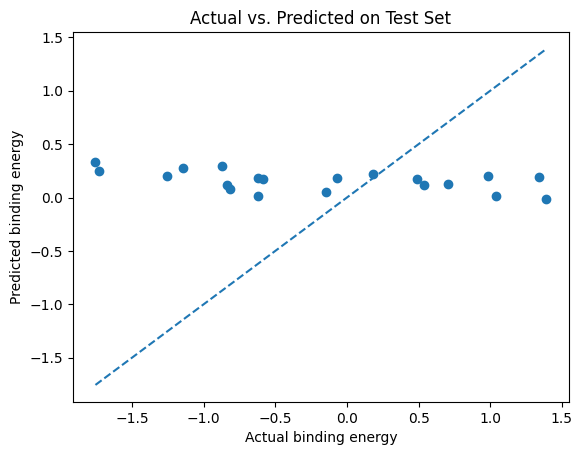

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         ls="--")  # diagonal line
plt.xlabel("Actual binding energy")
plt.ylabel("Predicted binding energy")
plt.title("Actual vs. Predicted on Test Set")
plt.show()


RuntimeError: Input type (double) and bias type (float) should be the same